In [1]:
import squigglepy as sq
import numpy as np

from datetime import datetime
from libs import plot_exponential_growth, fmt_worktime
from model_params import doubling_time, hacca_mode, reliability_metric, custom_end_year, custom_start_task_length, custom_launch_date
from model_data import model_data

print("Loaded libraries")

HACCA mode: True, reliability metric: performance_80p, custom_doubling_time: False, custom_start_task_length: None hrs

## START task length (displayed in sec) ##
{1: 1.0,
 5: 1.0,
 10: 1.0,
 20: 1.0,
 30: 1.09,
 40: 2.47,
 50: 5.13,
 60: 10.25,
 70: 20.34,
 80: 44.27,
 90: 114.93,
 95: 235.61,
 99: 843.75}



## HACCA task length (displayed in hrs) ##
{1: 40,
 5: 51,
 10: 80,
 20: 139,
 30: 206,
 40: 291,
 50: 402,
 60: 547,
 70: 768,
 80: 1148,
 90: 2002,
 95: 3153,
 99: 7377}



## DOUBLING TIME (displayed in days) ##
{1: 82,
 5: 105,
 10: 119,
 20: 139,
 30: 156,
 40: 171,
 50: 187,
 60: 204,
 70: 224,
 80: 251,
 90: 294,
 95: 334,
 99: 423}



## SHIFT (displayed in days) ##
{1: 0,
 5: 30,
 10: 56,
 20: 88,
 30: 111,
 40: 131,
 50: 149,
 60: 168,
 70: 188,
 80: 211,
 90: 243,
 95: 269,
 99: 318}
Loaded libraries


In [2]:
# Generate quarterly METR predictions (PUBLIC MODELS - NO SHIFT)
ref_model = 'gpt5'
reliability_metric_str = {
    'performance_50p': '50%',
    'performance_80p': '80%',
}
baseline_task_length = model_data[ref_model][reliability_metric]
baseline_launch_date = model_data[ref_model]['launch_date']
if hacca_mode and custom_start_task_length is not None:
    baseline_task_length = custom_start_task_length
    baseline_launch_date = custom_launch_date
print(f"METR Task Horizon Predictions ({reliability_metric_str[reliability_metric]} reliability) - PUBLIC MODELS")
print("=" * 70)
print(f"Baseline: GPT5 at {baseline_task_length:.1f}hr on {baseline_launch_date.strftime('%Y-%m-%d')}")
print("=" * 70)
print()


# Define quarters to predict (END of quarter)
def end_of_quarter(year, q):
    if q == 1:
        return datetime(year, 3, 31)
    elif q == 2:
        return datetime(year, 6, 30)
    elif q == 3:
        return datetime(year, 9, 30)
    else:  # q == 4
        return datetime(year, 12, 31)


quarters = []
end_year = 2030
if hacca_mode:
    end_year = custom_end_year
for year in range(2025, end_year):
    start_q = 3 if year == 2025 else 1
    for q in range(start_q, 5):
        quarters.append((year, q, end_of_quarter(year, q)))

# Sample parameters
n_samples = 50000
tau_samples = sq.sample(doubling_time, n=n_samples)

print(
    f"{'Quarter':<8} {'End Date':<12} {'Mean':<10} {'Median':<10} {'90% CI':<25} {'Days'}"
)
print("-" * 85)

# Find Mean and Median Task Time Horizons (TTHs) by quarters where milestones are reached with Mean and Median, along with the 90% CI in terms of TTHs for each quarter. 
results = []
for year, q, quarter_date in quarters:
    days_from_gpt5 = (quarter_date - baseline_launch_date).days

    if days_from_gpt5 < 0:
        continue

    task_lengths = np.zeros(n_samples)
    for i in range(n_samples):
        doublings = days_from_gpt5 / tau_samples[i]
        task_lengths[i] = baseline_task_length * (2**doublings)

    task_lengths = np.minimum(task_lengths, 2000)

    mean_val = np.mean(task_lengths)
    median_val = np.median(task_lengths)
    p5 = np.percentile(task_lengths, 5)
    p95 = np.percentile(task_lengths, 95)

    ci_str = f"[{fmt_worktime(p5)} - {fmt_worktime(p95)}]"
    date_str = quarter_date.strftime("%Y-%m-%d")

    print(
        f"{year}Q{q:<7} {date_str:<12} {fmt_worktime(mean_val):<10} {fmt_worktime(median_val):<10} {ci_str:<25} {days_from_gpt5:>4}"
    )

    results.append(
        {
            "quarter": f"{year}Q{q}",
            "date": quarter_date,
            "mean": mean_val,
            "median": median_val,
            "p5": p5,
            "p95": p95,
            "days": days_from_gpt5,
            "task_lengths": task_lengths,
        }
    )

    if q == 4:
        print()

# Show key milestones
print("\n" + "=" * 70)
print("Key Milestones (Median Estimates) - PUBLIC MODELS")
print("=" * 70)

# Updated milestones using work time
milestones = [
    (2, "2 hours"),
    (4, "4 hours"),
    (8, "1 day"),
    (16, "2 days"),
    (24, "3 days"),
    (40, "1 week"),
    (174, "1 month"),
]

# Show median estimates of key milestones i.e., the most likely quarter when the corresponding milestone is reached, along with the percent of samples.
for hours, name in milestones:
    for r in results:
        if r["median"] >= hours:
            prob = np.mean(r["task_lengths"] >= hours) * 100
            date_str = r["date"].strftime("%B %d, %Y")
            print(f"{name:<12} → {r['quarter']} ({date_str}, {prob:.0f}% of samples)")
            break
    else:
        if hacca_mode:
            print(f"{name:<12} → Not reached by 2034Q4")
        else:
            print(f"{name:<12} → Not reached by 2029Q4")

# Display the 90% CI for the key milestones in terms of the quarters when they are reached
print("\n" + "=" * 70)
print("90% Confidence Intervals for Key Milestones - PUBLIC MODELS")
print("=" * 70)
for hours, name in milestones:
    p5_date = None
    p95_date = None
    for r in results:
        if r["p5"] >= hours and p5_date is None:
            p5_date = r["date"].strftime("%B %d, %Y")
        if r["p95"] >= hours and p95_date is None:
            p95_date = r["date"].strftime("%B %d, %Y")
        if p5_date is not None and p95_date is not None:
            break
    if p5_date is None:
        p5_date = "Not reached by 2029Q4"
        if hacca_mode:
            p5_date = "Not reached by 2034Q4"
    if p95_date is None:
        p95_date = "Not reached by 2029Q4"
        if hacca_mode:
            p95_date = "Not reached by 2034Q4"
    print(f"{name:<12} → [{p95_date} - {p5_date}]")
    

METR Task Horizon Predictions (80% reliability) - PUBLIC MODELS
Baseline: GPT5 at 0.4hr on 2025-08-07

Quarter  End Date     Mean       Median     90% CI                    Days
-------------------------------------------------------------------------------------
2025Q3       2025-09-30   31min      30min      in - 35min]             54
2025Q4       2025-12-31   45min      42min      in - 1.1hr]            146

2026Q1       2026-03-31   1.1hr      59min      in - 2.0hr]            236
2026Q2       2026-06-30   1.7hr      1.4hr      in - 3.6hr]            327
2026Q3       2026-09-30   2.8hr      2.0hr      in - 6.6hr]            419
2026Q4       2026-12-31   4.6hr      2.8hr      [1.2hr - 1.5d]             511

2027Q1       2027-03-31   7.8hr      3.9hr      [1.5hr - 2.7d]             601
2027Q2       2027-06-30   1.7d       5.4hr      [1.8hr - 4.9d]             692
2027Q3       2027-09-30   3.1d       7.6hr      [2.1hr - 1.8wk]            784
2027Q4       2027-12-31   1.0wk      1.3d  

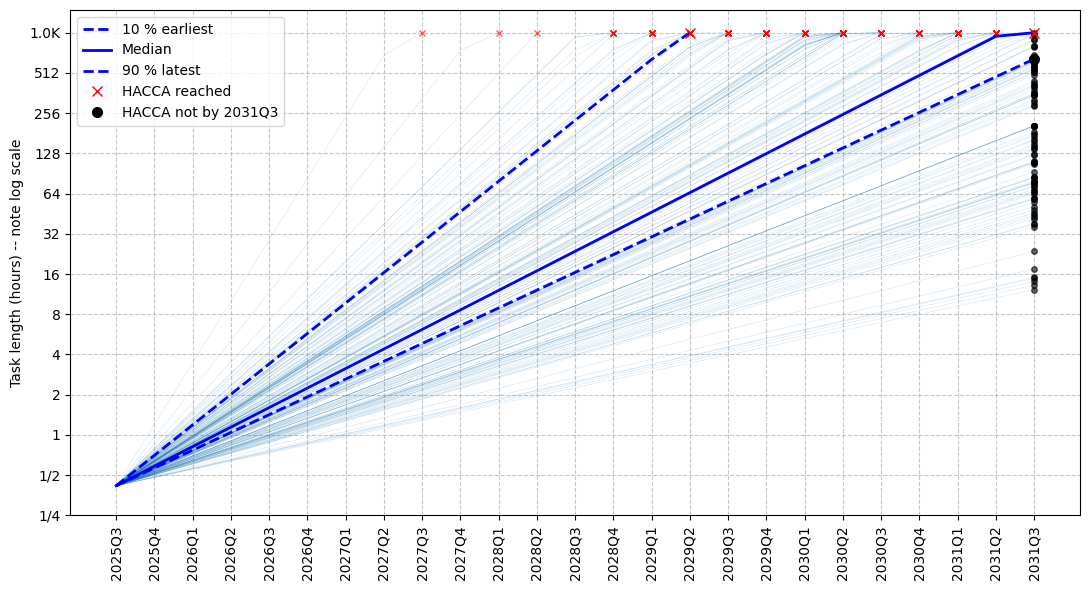

In [3]:
plot_exponential_growth(
    doubling_time_days=doubling_time,
    start_hours=baseline_task_length,
    start_date=baseline_launch_date,
    agi_task_length=100_000,
    shift=0,
    n_quarters=24,
    n_samples=100_000,
    n_traces=200,
    max_task_power=10,
)

In [4]:
def predict(from_model, for_model, debug=False):
    if isinstance(from_model, str):
        from_model = model_data[from_model]
    if isinstance(for_model, str):
        for_model = model_data[for_model]

    print(f"PREDICT {from_model['name']} -> {for_model['name']}")
    days_since = (for_model['launch_date'] - from_model['launch_date']).days

    def extrapolation():
        individual_model_idiosyncratic_variation = sq.norm(0.75, 1/0.75, lclip=0.1)
        doublings = days_since / doubling_time
        return from_model[reliability_metric] * (2**doublings) * individual_model_idiosyncratic_variation

    if debug:
        return {'from_model': from_model,
                'for_model': for_model,
                'days_since': days_since,
                'doubling_time': doubling_time,
                'doublings': days_since / doubling_time,
                'from_perf': from_model[reliability_metric]}
    else:
        samples = sq.sample(extrapolation, n=50_000, verbose=True)
        mean_ci = sq.get_mean_and_ci(samples, credibility=80)
        print(f"Predicted: {fmt_worktime(mean_ci['mean'])} (80%CI: {fmt_worktime(mean_ci['ci_low'])} - {fmt_worktime(mean_ci['ci_high'])})")
    
        if for_model.get(reliability_metric):
            print(f"Actual observed: {for_model['name']} at {for_model[reliability_metric]:.1f}hr")
        return samples

_ = predict(from_model='o3', for_model='claude_4_opus')

PREDICT o3 -> Claude 4 Opus


100%|██████████| 50000/50000 [00:07<00:00, 6909.35it/s]


Predicted: 24min (80%CI: 18min - 29min)
Actual observed: Claude 4 Opus at 0.3hr


In [5]:
_ = predict(from_model='o3', for_model='gpt5')

PREDICT o3 -> GPT5


100%|██████████| 50000/50000 [00:07<00:00, 6768.94it/s]

Predicted: 33min (80%CI: 23min - 43min)
Actual observed: GPT5 at 0.4hr


In [6]:
_ = predict(from_model='o3', for_model={'name': 'TODAY', 'launch_date': datetime.now()})

PREDICT o3 -> TODAY


100%|██████████| 50000/50000 [00:07<00:00, 6800.08it/s]


Predicted: 45min (80%CI: 29min - 1.1hr)


In [7]:
_ = predict(from_model='gpt5', for_model={'name': 'TODAY', 'launch_date': datetime.now()})

PREDICT GPT5 -> TODAY


100%|██████████| 50000/50000 [00:07<00:00, 6693.13it/s]


Predicted: 35min (80%CI: 26min - 44min)


In [8]:
_ = predict(from_model='o3', for_model='claude_4p5_sonnet')

PREDICT o3 -> Claude 4.5 Sonnet


100%|██████████| 50000/50000 [00:22<00:00, 2228.75it/s]

Predicted: 41min (80%CI: 27min - 57min)


In [9]:
c4o_samples = predict(from_model='claude_4_opus', for_model='claude_4p5_sonnet')

PREDICT Claude 4 Opus -> Claude 4.5 Sonnet


100%|██████████| 50000/50000 [00:23<00:00, 2153.41it/s]

Predicted: 35min (80%CI: 25min - 47min)


In [10]:
c4o_samples = predict(from_model='claude_4p1_opus', for_model='claude_4p5_sonnet')

PREDICT Claude 4.1 Opus -> Claude 4.5 Sonnet


100%|██████████| 50000/50000 [00:24<00:00, 2073.32it/s]


Predicted: 27min (80%CI: 20min - 33min)


In [11]:
gpt5_samples = predict(from_model='gpt5', for_model='claude_4p5_sonnet')

PREDICT GPT5 -> Claude 4.5 Sonnet


100%|██████████| 50000/50000 [00:23<00:00, 2165.65it/s]

Predicted: 32min (80%CI: 24min - 39min)


In [12]:
mixed_samples = np.concatenate([c4o_samples, gpt5_samples])
mean_ci = sq.get_mean_and_ci(mixed_samples, credibility=80)
print(f"Predicted: {fmt_worktime(mean_ci['mean'])} (80%CI: {fmt_worktime(mean_ci['ci_low'])} - {fmt_worktime(mean_ci['ci_high'])})")

Predicted: 29min (80%CI: 22min - 37min)


In [13]:
bins = [0, 1.5, 2, 2.5, 3, 3.5, 4, 5, 6, 7]
labels = ['<1.5h', '1.5h - 2h', '2h - 2.5h', '2.5h - 3h', '3h - 3.5h', 
          '3.5h - 4h', '4h - 5h', '5h - 6h', '6h - 7h']

counts, _ = np.histogram(mixed_samples, bins=bins)
percentages = 100 * counts / len(mixed_samples)

for label, pct in zip(labels, percentages):
    print(f"{label} {pct:.1f}%")

<1.5h 100.0%
1.5h - 2h 0.0%
2h - 2.5h 0.0%
2.5h - 3h 0.0%
3h - 3.5h 0.0%
3.5h - 4h 0.0%
4h - 5h 0.0%
5h - 6h 0.0%
6h - 7h 0.0%
